In [2]:
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import glob
import pickle
import sklearn.metrics as skmetrics

In [5]:
from scipy.special import j0 as bessel_j0

distances = np.array([0.1]+[0.2]*98)

def transform_to_spatial_freq(r, R_r, k, distances=distances):

    res = 2 * np.pi * np.sum(r * bessel_j0(k * r) * R_r * distances)/1000/1000
    return res

In [7]:
def calculate_real_frequencies_from_prepends(freq_prepends):
    """
    calculate real spatial frequencies k = 2pi/L from frequencies prepends
    """
    return 2 * np.pi * np.array([x / 160. for x in [float(x) for x in freq_prepends]])

In [8]:

freqs = ['01', '02', '04', '06', '10', '12', '14', '22', '26', '40', '44']
ks = calculate_real_frequencies_from_prepends(freqs)

In [9]:
def get_Rk(R_r, r, ks):
    R_k = []
    for k in ks:
        R_k.append(transform_to_spatial_freq(r, R_r, k))
        
    return np.array(R_k)

In [10]:
df = pd.read_pickle('data/modeling_results_SFDI_11_ext.pkl')

Text(0, 0.5, 'Reflection coefficient')

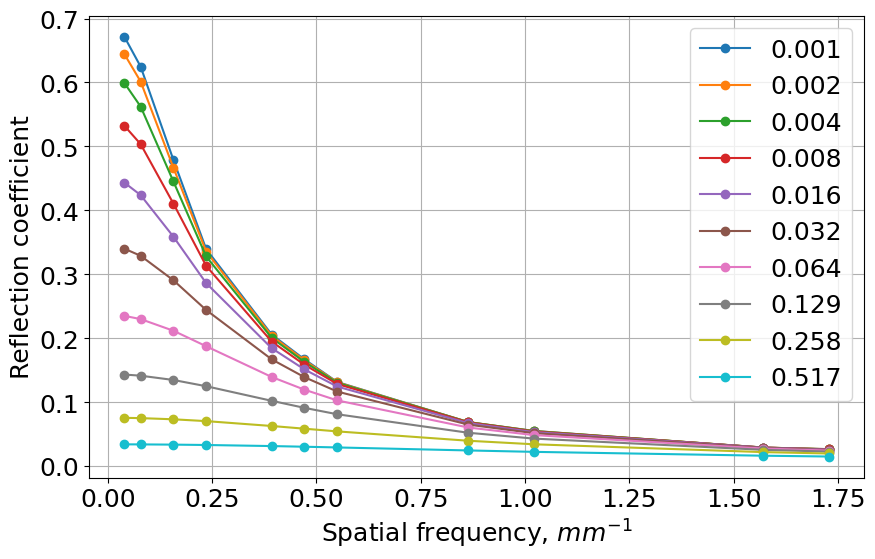

In [12]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
plt.figure(figsize=(10,6))

for i in range(1,20_000,2000):
    plt.plot(ks[:],df.R_k.iloc[i],'o-',
             label=f'{np.round(np.float64(df.iloc[i].mua),3)}')
    #plt.yscale('log')
plt.legend()
plt.grid()
plt.xlabel('Spatial frequency, $mm^{-1}$')
plt.ylabel('Reflection coefficient')

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2)
X_train = df_train.R_k.apply(lambda x: x[::]).values
y_train = np.array(df_train[['mua']].values).astype(float)
X_train = np.array(list(X_train))


X_test = df_test.R_k.apply(lambda x: x[::]).values
y_test = np.array(df_test[['mua']].values).astype(float)
X_test = np.array(list(X_test))


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(float)
X_test = scaler.transform(X_test).astype(float)

In [16]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()
from sklearn.model_selection import GridSearchCV
k_range = list(range(2, 8))
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(neigh,
                    param_grid, cv=4, scoring='neg_mean_squared_error', return_train_score=True,verbose=3)
  
# fitting the model for grid search
grid_search_knn = grid.fit(X_train, y_train)


Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV 1/4] END n_neighbors=2;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 2/4] END n_neighbors=2;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 3/4] END n_neighbors=2;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 4/4] END n_neighbors=2;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 1/4] END n_neighbors=3;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 2/4] END n_neighbors=3;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 3/4] END n_neighbors=3;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 4/4] END n_neighbors=3;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 1/4] END n_neighbors=4;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 2/4] END n_neighbors=4;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 3/4] END n_neighbors=4;, score=(train=-0.000, test=-0.000) total time=   0.0s
[CV 4/4] END n_neighbors=4;, score=(tr

In [18]:
regressor_mua = grid_search_knn.best_estimator_
regressor_mua.fit(X_train,y_train)

KNeighborsRegressor()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


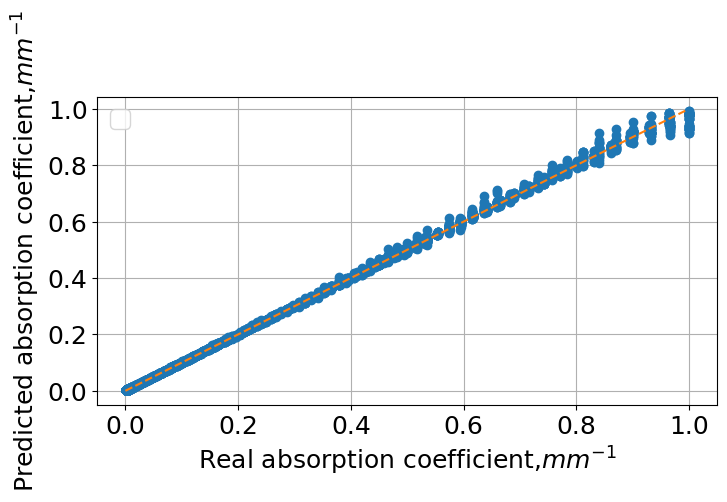

In [21]:
plt.figure(figsize=(8,4))
list1 = regressor_mua.predict(X_test).reshape(-1,1)
list1 = np.array(list1, dtype=float)
list2 = y_test
list2 = np.array(list2,dtype=float)


plt.plot(list2,list1,'o')
x = np.linspace(0,max(list1),100)
plt.plot(x,x,'--')
plt.xlabel('Real absorption coefficient,$mm^{-1}$')
plt.ylabel('Predicted absorption coefficient,$mm^{-1}$')
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


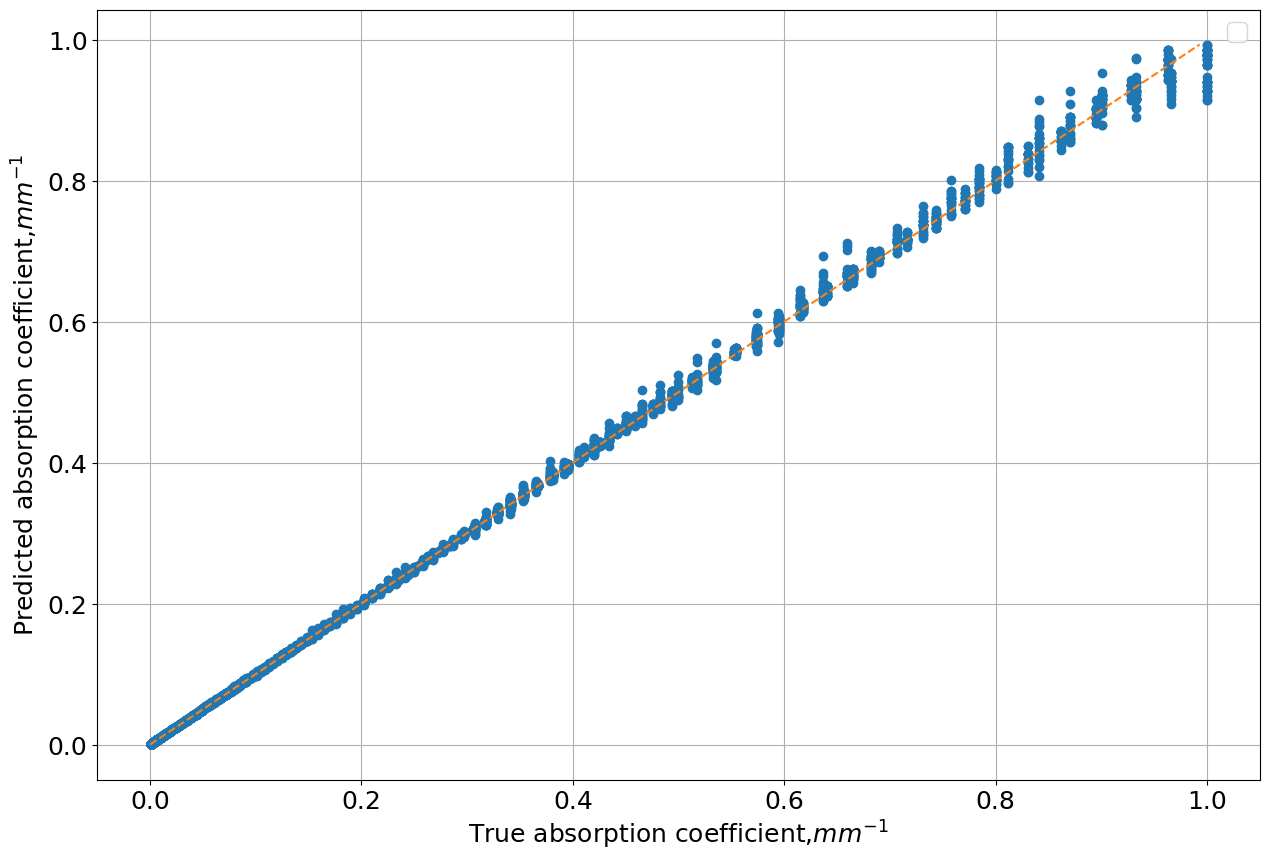

In [22]:
plt.figure(figsize=(15,10))
list1 = regressor_mua.predict(X_test).reshape(-1,1)
list1 = np.array(list1, dtype=float)
list2 = y_test
list2 = np.array(list2, dtype=float)


plt.plot(list2,list1,'o')
x = np.linspace(0,max(list1),100)
plt.plot(x,x,'--')
plt.xlabel('True absorption coefficient,$mm^{-1}$')
plt.ylabel('Predicted absorption coefficient,$mm^{-1}$')
plt.legend()
plt.grid()